Программа получает на вход файлы из папки, в которых содержатся данные для построения графиков, отрисовывает каждый график и по надобности сохраняет его. Дополнительно увеличение по временному масштабу 100 нс, 1 мкс, 10 мкс.  
_______
**Названия рисунков**  
AAA.A_CCC_D_E_10us.png 
AAA.A – Толщина образца и порядковый номер (400.1)  
BBBBBB – День эксперимента  - день месяц год(060924)  
CCC – Номер эксперимента (001)  
D – Количество импульсов(1)  
E – Энергия в импульсе нДж (5)  
F - Увеличение(10us)  
____
**Пример** получившегося названия:  
400.1.060924.001.1.5.png

#### Задачи:
- Доступ к общей таблице
- Увеличение графиков
- Название файлов
- Перевод в Вт
- Начало с какого файла
- Обрабатывать новые файлы в режиме реального времени
- Производить увеличение второго графика спустя задержку ~80нс плюс отступ назад 5нс, и от этой точки взять 100 нс, 1 мкс или 10 мкс

In [ ]:
!pip install pandas matplotlib openpyxl

Num: 18
shot18.csv


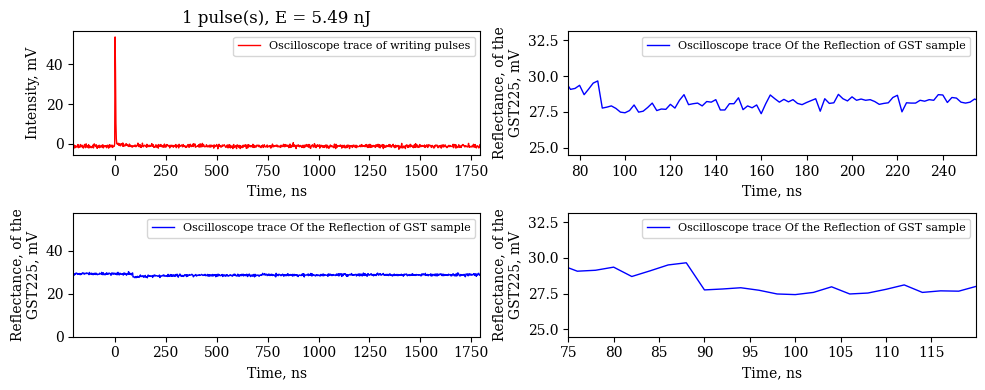

Num: 19
shot19.csv


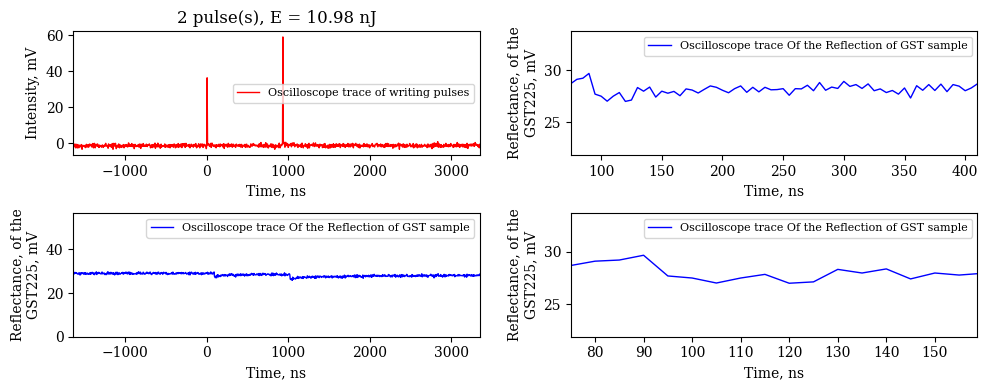

Num: 20
shot20.csv


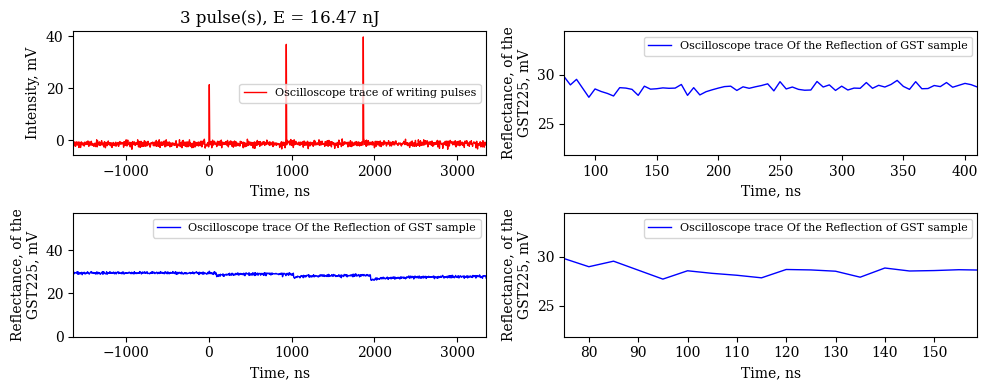

Num: 21
shot21.csv


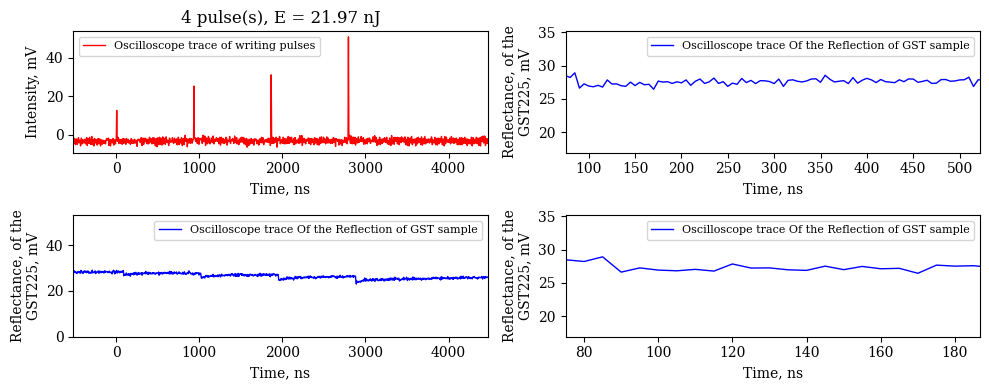

Num: 22
shot22.csv


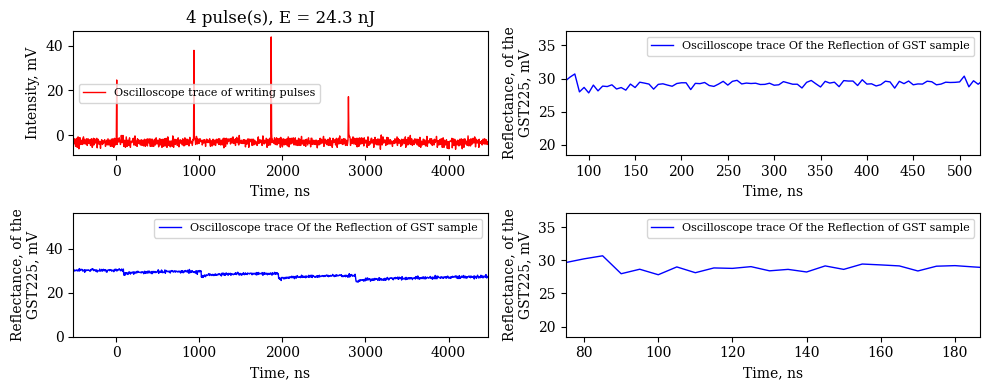

Num: 23
shot23.csv


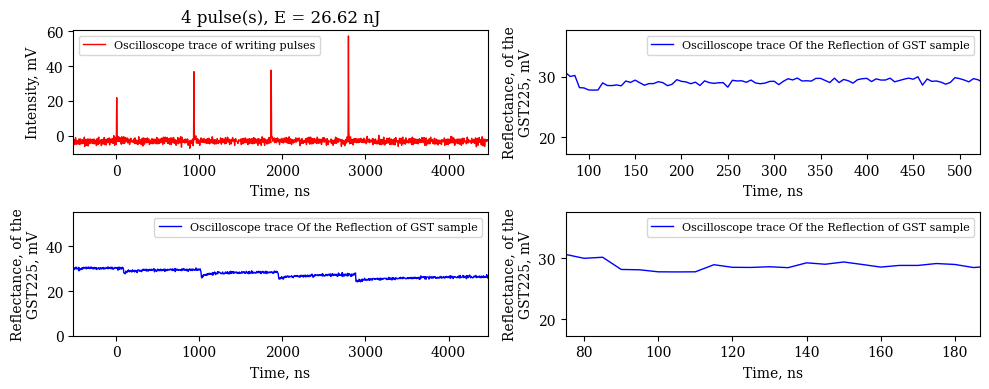

Num: 24
shot24.csv


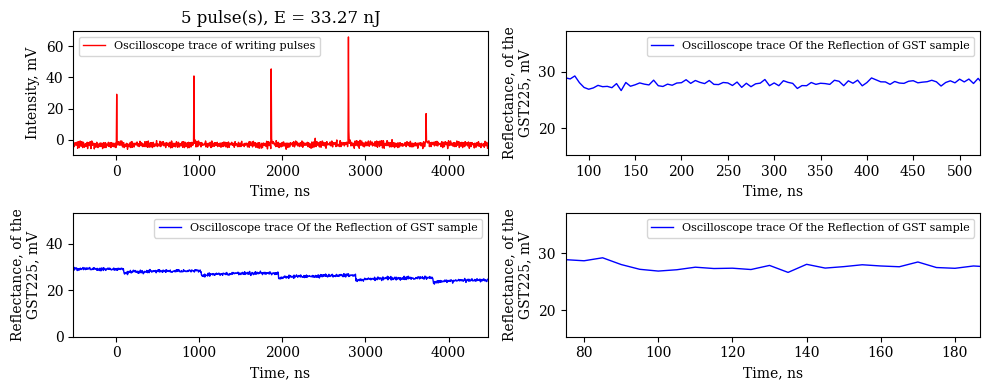

Num: 25
shot25.csv


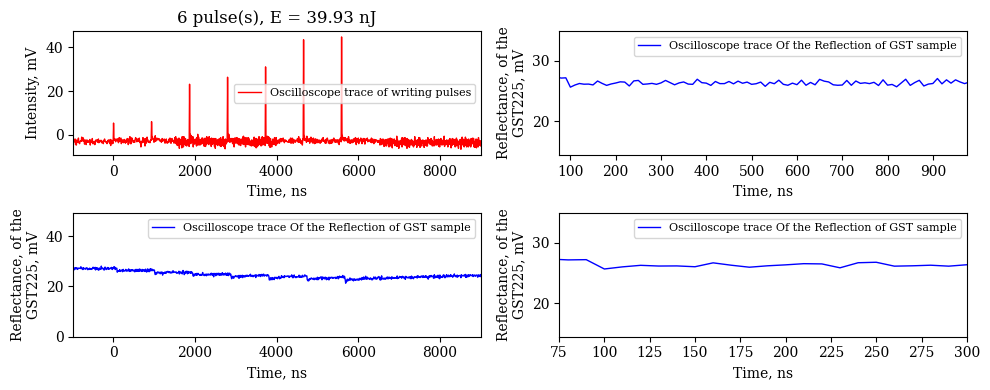

Num: 26
shot26.csv


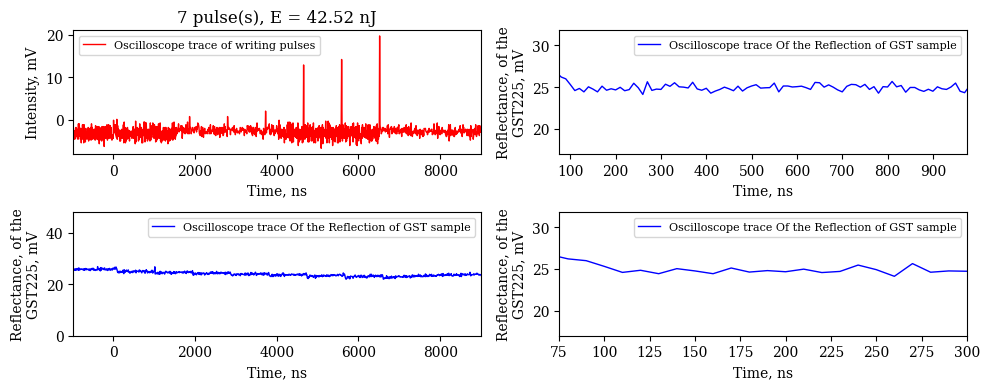

Num: 27
shot27.csv


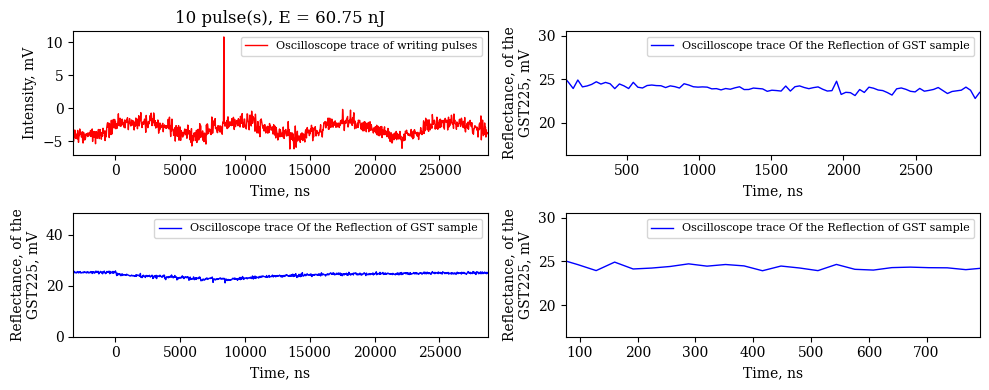

Num: 28
shot28.csv


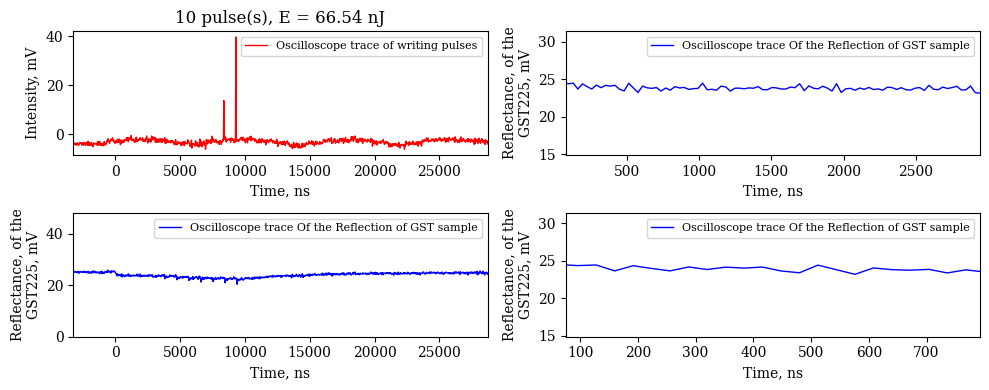

Num: 29
shot29.csv


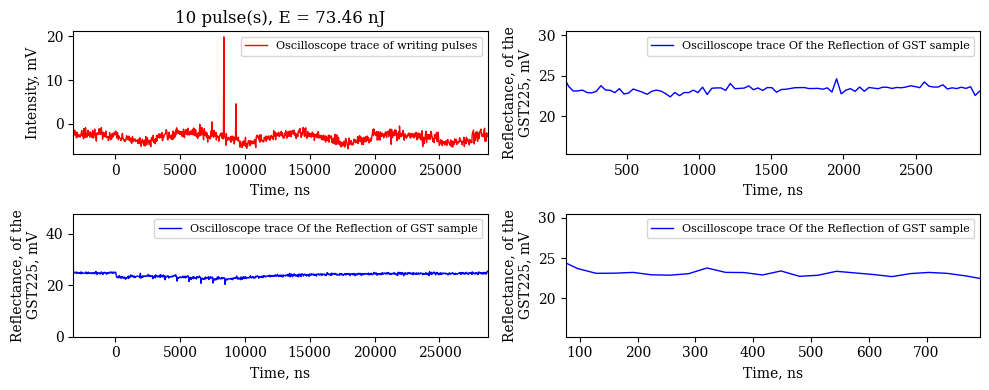

Num: 30
shot30.csv


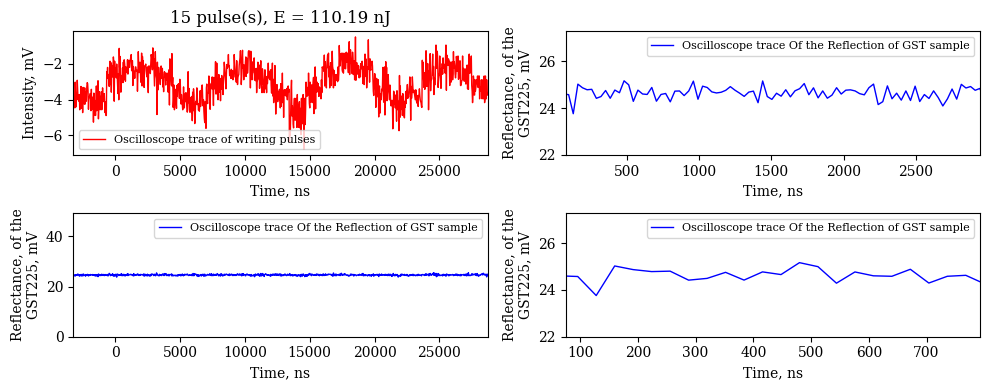

Num: 31
shot31.csv


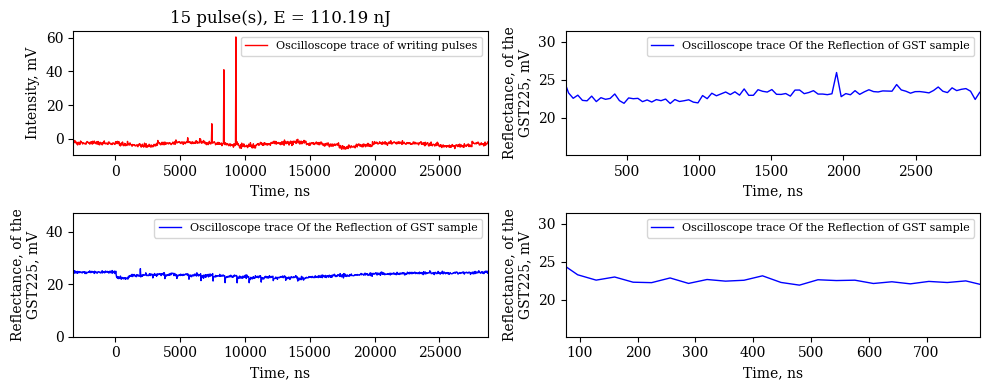

Num: 32
shot32.csv


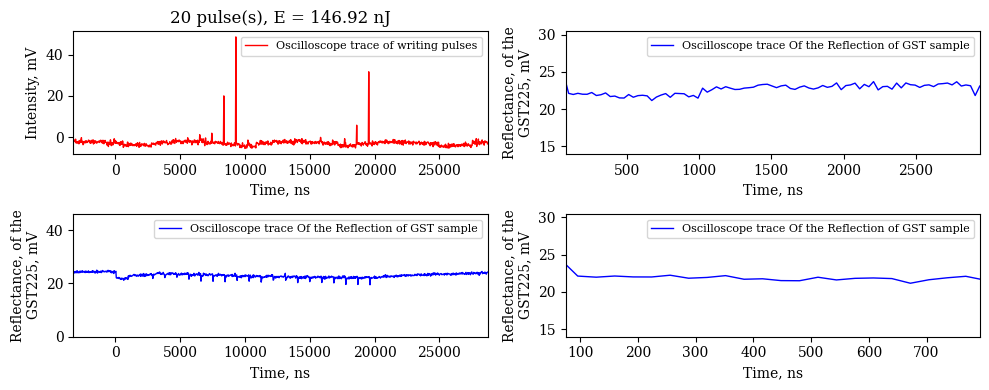

Num: 33
shot33.csv


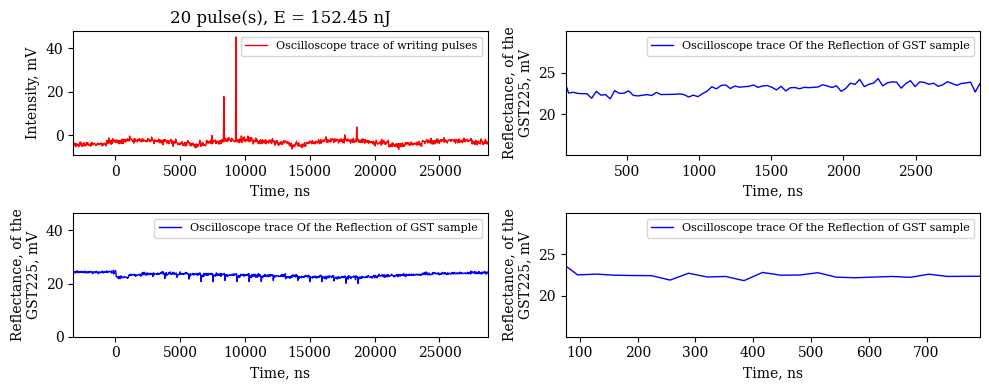

Num: 35
shot35.csv


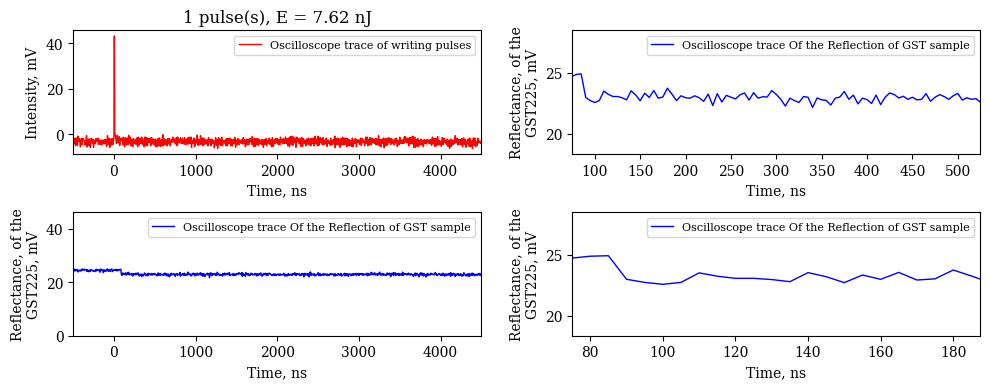

Num: 36
shot36.csv


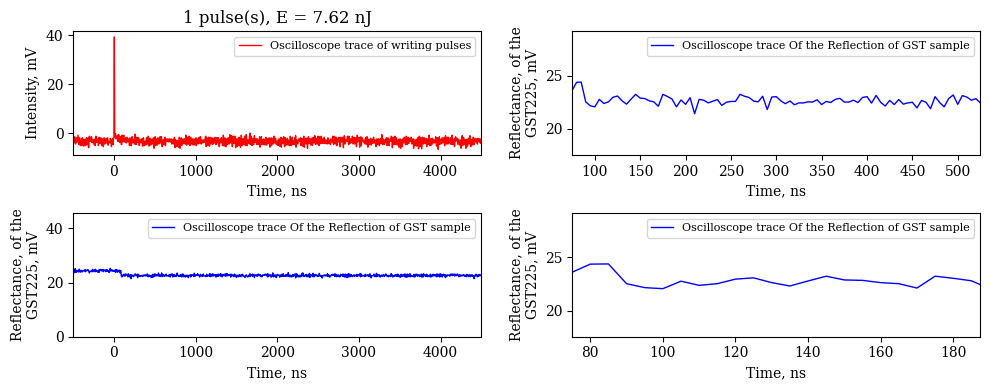

Num: 37
shot37.csv


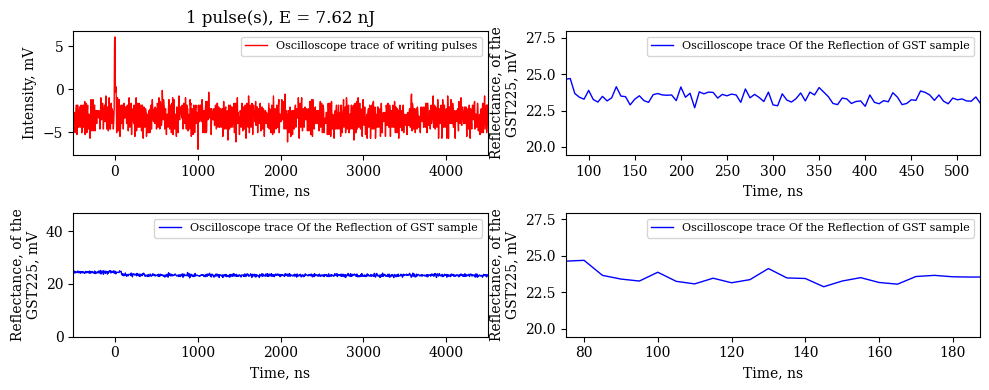

Num: 38
shot38.csv


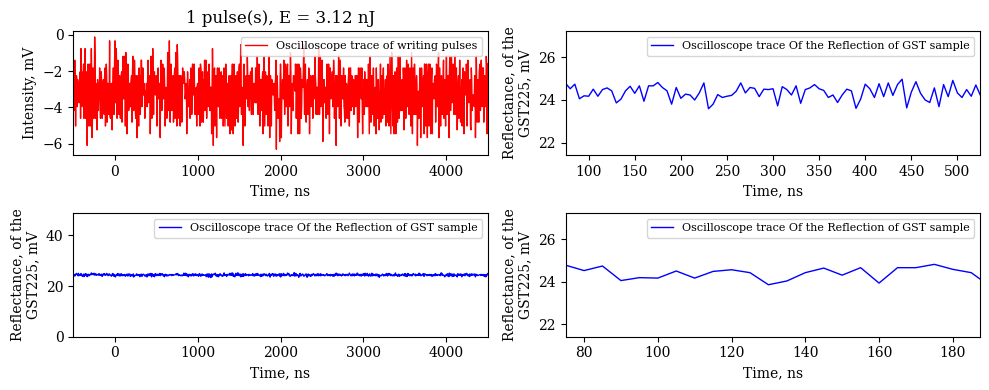

Num: 39
shot39.csv


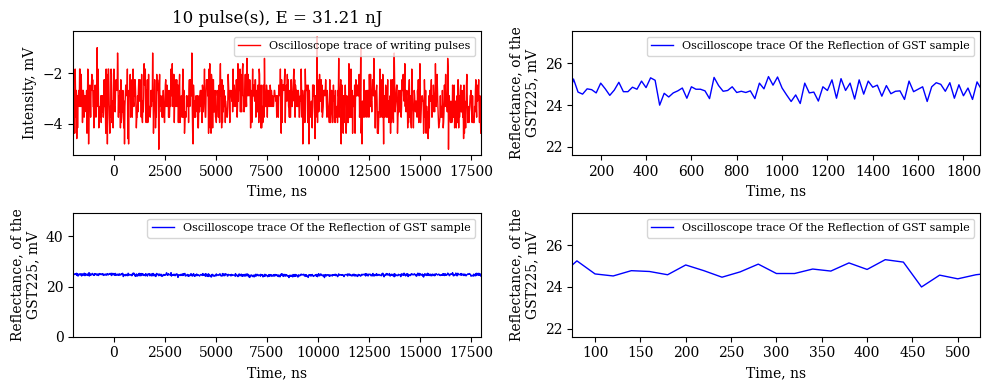

Num: 40
shot40.csv


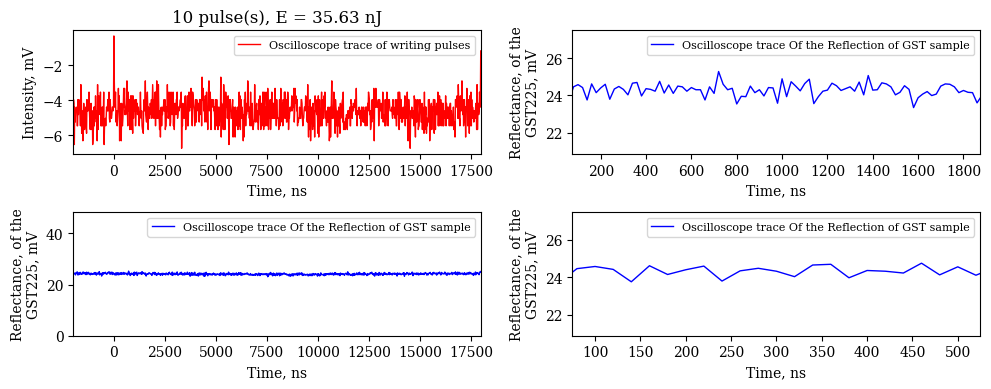

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os 
import numpy as np

start_file = 'shot18.csv' # Rigol
# start_file = 'Tek004_ALL.csv' # Tektronix

# dir = 'waveforms/110924/' # папка с осциллограммами
dir = 'waveforms/060924/Осциллограммы переходов/' # папка с осциллограммами
general_file = 'waveforms/060924/General.xlsx'
files = sorted(os.listdir(dir))

csv_files_all = [file for file in files if (file.endswith('.csv'))]
csv_files = [file for file in csv_files_all if (file.startswith('shot') or file.startswith('Tek'))]

df_gen = pd.read_excel(general_file)
col_index = df_gen.columns.get_loc('Общая энергия, нДж')
df_gen = df_gen.iloc[:, :col_index+1]



def plot_graph(pulses, energy):
    plt.figure(figsize=(10, 4))
    plt.rcParams["font.family"] = "serif" # font

    # 1) Без увеличения
    plt.subplot(2, 2, 1)
    plt.xlim(df.iloc[0, 0]*1e9, df.iloc[-1, 0]*1e9)
    plt.ylabel('Intensity, mV', fontsize=10)
    plt.xlabel('Time, ns', fontsize=10)
    plt.plot(df['TIME']*1e9, df['CH1']*1e3, color='red', linewidth=1,
             label='Oscilloscope trace of writing pulses')
    plt.title(label= f'{pulses} pulse(s), E = {energy} nJ')
    plt.legend(fontsize=8)


    plt.subplot(2, 2, 3)
    plt.xlim(df.iloc[0, 0]*1e9, df.iloc[-1, 0]*1e9)
    plt.ylim(0, y_avg*1e3*2)
    plt.ylabel(r'Reflectance, of the' + '\n' +'GST225, mV', fontsize=10)
    plt.xlabel('Time, ns', fontsize=10)
    plt.plot(df['TIME']*1e9, df['CH2']*1e3, color='blue', linewidth=1,
             label='Oscilloscope trace Of the Reflection of GST sample')
    plt.legend(fontsize=8)


    # 2) Увеличение
    plt.subplot(2, 2, 2)
    plt.xlim(75, 75+df.iloc[-1, 0]*1e9 / 10)
    plt.ylim(y_start*1e3, y_end*1e3)
    plt.ylabel(r'Reflectance, of the' + '\n' +'GST225, mV', fontsize=10)
    plt.xlabel('Time, ns', fontsize=10)
    plt.plot(df['TIME']*1e9, df['CH2']*1e3, color='blue', linewidth=1,
             label='Oscilloscope trace Of the Reflection of GST sample')
    plt.legend(fontsize=8)


    # 3) Увеливение
    plt.subplot(2, 2, 4)
    plt.xlim(75, 75+df.iloc[-1, 0]*1e9 / 40)
    plt.ylim(y_start*1e3, y_end*1e3)
    plt.ylabel(r'Reflectance, of the' + '\n' +'GST225, mV', fontsize=10)
    plt.xlabel('Time, ns', fontsize=10)
    plt.plot(df['TIME']*1e9, df['CH2']*1e3, color='blue', linewidth=1,
             label='Oscilloscope trace Of the Reflection of GST sample')
    plt.legend(fontsize=8)

    plt.tight_layout()  # Автоматическая регулировка расстояния между графиками
    

# Узнаем номер снимка
def osc_number(file):
    if ('Tek' in file):
        exp_number = file.replace('Tek', '')
        exp_number = exp_number.replace('_ALL.csv', '')
    else:
        exp_number = file.replace('shot', '')
        exp_number = exp_number.replace('.csv', '')
        exp_number = exp_number.replace(' ', '')
    print("Num:", exp_number)

    return int(exp_number)


start_index = csv_files.index(start_file)
for file in csv_files[start_index:]:
    path = dir + file

    # Для пропуска любой "Шапки" файла
    f = open(path, 'r')
    lines = f.readlines()
    skip_lines = next(i for i, line in enumerate(lines) 
                  if 'TIME' in line or 'Time(s)' in line)
    f.close()

    # Номер эксперимента, кол-во импульсов, энергия
    num = osc_number(file)
    pulses = df_gen.loc[df_gen['Shot'] == num, 'Количество'].iloc[0]
    energy = round(df_gen.loc[df_gen['Shot'] == num, 
                              'Общая энергия, нДж'].iloc[0], 2)
    
    flag_pulse = 'many' if pulses > 1 else 'one' 
    

    column_names = ['TIME', 'CH1', 'CH2', 'CH3']
    df = pd.read_csv(path, skiprows=skip_lines+1, header=None, names=column_names)
    df = df.drop('CH3', axis=1)
    df.replace(np.inf, np.nan, inplace=True) # Если есть значения Inf
    df.replace(-np.inf, 0.000000001212, inplace=True)

    diff = df['CH2'].max()-df['CH2'].min()
    y_start = df['CH2'].min() - diff
    y_end = df['CH2'].max() + diff
    y_avg = df['CH2'].mean()

    df.replace(np.nan, np.inf, inplace=True) # Если есть значения Inf
    df.replace(0.000000001212, -np.inf, inplace=True)

    print(file)
    plot_graph(pulses, energy)
    plt.show()
    

    # save = input('Save?(y or n): ')
    # if(save == 'y'): 
    #     plot_graph()
    #     plt.savefig('013.png', dpi=300, bbox_inches='tight')

    # plt.close()

    